## Problema Uno

#### Se realizaron multiples iteraciones para encontrar la mejor función cromosoma posible. Particularmente

#### - Secuencia directa de movimientos, donde se codificó un string de movimientos (arriba, abajo, derecha, izquierda) con tamaño definido. Sin embargo encontramos que hay problemas porque la parte importante de los individuos en general es la primera parte exitosa. Debido a esto, la función de mutación y de crossover por partición es poco eficiente. Crossover en el que cada instrucción provenía aleatoriamente de uno de los dos padres tuvo mejor desempeño pero no fue una solución escalable porque las diferencias entre generaciones no provocaban mejoras en el fitness y por lo tanto se estancaba la mejoría.

#### - Conjunto de reglas basada en paredes circundantes, se definió un input (los sensores de las 4 direcciones) y una respuesta (acción). La solución demostró tiempos rapidos de ejecución pero ante mismas circunstancias tomaba decisiones deterministicas, por lo que nunca lograría resolver ciertos casos repetitivos dentro de un laberinto.

#### - Maquina de Mealy con paredes circundantes, se implementó el mismo caso que antes excepto que dentro del input había un estado y como output sacaba una acción pero también un nuevo estado. Con 4 estados el programa fue exitoso para casos pequeños pero a medida que se escalaba el problema, la solución no mejoraba y aumentar el numero de estados creó un estado de abstracción que el mismo programa no pudo interpretar, resultando en soluciones no beneficas.

#### Finalmente, se escogió una versión de la secuencia directa de movimientos. Todos los individuos validos consisten en un string de instrucciones (avanzar, derecha, izquierda). La función cromosoma asigna con mayor probabilidad avanzar, pues es una instrucción en general mas util para laberintos. En cada generación se asigna un tamaño a los individuos, donde el tamaño corresponde al numero de instrucciones. Dada una solución de la forma u + v donde u y v son strings de instrucciones y u es una buena solución, la intuición dictamina que en general queremos mutar sobre v y no sobre u, y hacer crossovers donde se combinan u1 con u2 y v1 con v2. Por esta naturaleza, se decidió crear "Eventos evolucionarios críticos", en este caso se designan como "logros generacionales" que permiten que la longitud de los individuos aumente. Esta solución demostró ser altamente eficiente excepto cuando hay rutas suboptimas largas. Para ello se definió un indicador de estagnación que ante paro en crecimiento del mejor fitness generacional, se comienza a mutar cada vez más partes de u, en general la cola de u. 

#### Esta propuesta corre casos pequeños con altas tasas de exito y en general en 10 generaciones. Sin embargo, al momento de escalar la solución al caso heavy hay una tasa de exito del ~14%, en donde lo resuelve en 200 generaciones. Para poder mejorar esta solución se recomendaría implementar una función de estagnación más robusta y permitir mayor exploración en puntos de decisión teniendo en cuenta las paredes circundantes permitiendo crear drifts geneticos (entiendase como una población aislada que explora una decisión especifica en un punto de decisión). Al pasar x generaciones se evalua si el drift fue exitoso, de no haberlo sido, se mata. Estas modificaciones implican mayor procesamiento por generación y aumentar dinamicamente el tamaño generacional al haber multiples poblaciones en ciertos momentos. Sin embargo, se cree que podría escalar con mayor facilidad y aumentar la tasa de exito.

#### Ahora, se hablará de 3 operaciones de cruce que se evaluaron. Cabe resaltar que por la propiedad del problema mencionada previamente se descartaron algunas opciones rapidamente, por supuesto constatando con la evolución de la función de fitness.

#### - Sean u y v individuos de longitud k, se escoge un numero pseudoaleatorio m, tal que 0 <= m <= k. A continuación se unen u entre la posición 0 y m, y v entre la posición m + 1 y k.

#### - Sean u y v individuos de longitud k se devuelve un individuo con genes w tal que w[i] = u[i] si un numero entre 0 y 1 es menor a 0.5, v[i] de lo contrario.

#### - Sean u, v y w individuos de longitud k, se escoge un numero pseudoaleatorio m, tal que 0 <= m <= k y m <= r <= k. A continuación se unen u entre la posición 0 y m, v entre la posición m + 1 y r, y w entre la posicion r+1 y k.

#### Debido al algoritmo planteado la convergencia no es estrictamente ascendente y en ocasiones baja, sin embargo la tendencia es alzista. Como se puede ver, el algoritmo sube en fitness muy rapido inicialmente y a medida que progresa con menor ascenso.

#### A continuación se muestra la resolución del maze heavy:

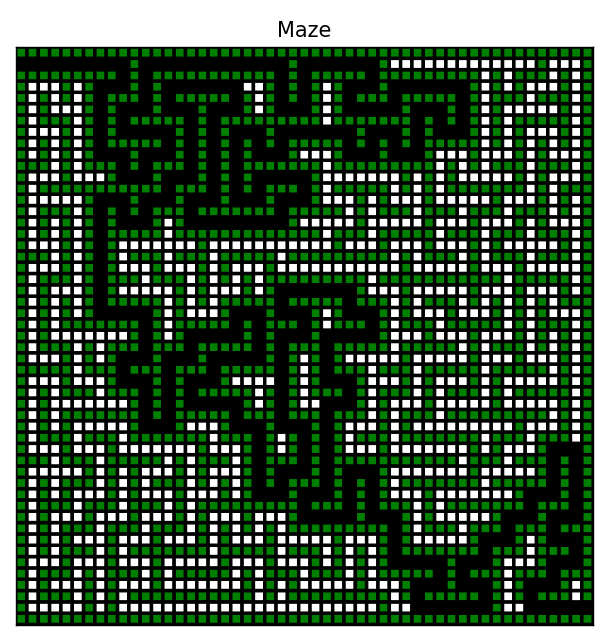

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import time

N_GEN = 250
N_POP = 250
mutate_rate = 0.1
CNG_LEN = 5


def simulate(maze, commands, start=(1, 0), start_dir=0, show=False):
    # Directions: Up, Right, Down, Left
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    x, y = start
    dir_idx = start_dir
    steps = 0

    for cmd in commands:
        if show:
            print(x, y)
        if cmd == "L":
            dir_idx = (dir_idx - 1) % 4
        elif cmd == "R":
            dir_idx = (dir_idx + 1) % 4

        dx, dy = directions[dir_idx]
        nx, ny = x + dx, y + dy
        if show:
            print("> ", nx, ny)
        if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0:
            x, y = nx, ny
            if show:
                print("DS")
            steps += 1
        else:
            return (x, y), 1, steps

    return (x, y), 0, steps


def fitness(indiv, maze):
    end_pos = (len(maze) - 2, len(maze[0]) - 1)
    (x, y), penalties, steps = simulate(maze, indiv)

    dist = abs(end_pos[0] - x) + abs(end_pos[1] - y)

    score = -dist * 5 - penalties * 800 + steps * 25

    if (x, y) == end_pos:
        score += 1e8

    return score


def generarGen():
    return random.choice(["S"] * 3 + ["L"] + ["R"])


def cromosoma(longitudInicial):
    return [generarGen() for _ in range(longitudInicial)]


def agregarCromosoma(cromosoma, aAgregar):
    return cromosoma + [generarGen() for _ in range(aAgregar)]


def crossover(indiv1, indiv2):
    return indiv1[: len(indiv1) - CNG_LEN] + indiv2[-CNG_LEN:]


def mutate(indiv, stagIndex):
    for i in range(len(indiv) - int(1.5 * CNG_LEN) - stagIndex, len(indiv)):
        if random.random() < 0.6:
            indiv[i] = generarGen()

    return indiv


def select(population, maze):
    tournament = random.sample(population, 5)
    return max(tournament, key=lambda indiv: fitness(indiv, maze))


def imprimir(poblacion, maze):
    best = poblacion[0]
    path_maze = maze.copy()
    x, y = 1, 0
    dir_idx = 0
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    path_maze[x][y] = 2

    for cmd in best:
        if cmd == "L":
            dir_idx = (dir_idx - 1) % 4
        elif cmd == "R":
            dir_idx = (dir_idx + 1) % 4

        dx, dy = directions[dir_idx]
        nx, ny = x + dx, y + dy
        if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0:
            x, y = nx, ny
            path_maze[x][y] = 2

    display_maze(path_maze)


def isFitnessStagnant(fit):
    if len(fit) > 1:
        baseline = fit[len(fit) - 1]
    cou = 0

    for i in reversed(range(0, 250)):
        if i not in fit:
            break

        if fit[i] != baseline:
            break

        cou += 1

    if cou > 10 and cou < 15:
        return CNG_LEN * 1

    if cou >= 15 and cou < 20:
        return CNG_LEN * 2

    if cou >= 20:
        return CNG_LEN * 3

    return 0


def genetico(maze):
    start = time.time()

    lenIndiv = CNG_LEN
    poblacion = [cromosoma(lenIndiv) for _ in range(N_POP)]
    poblacion.sort(key=lambda indiv: fitness(indiv, maze), reverse=True)
    fit = {}
    mejor = [-1e9, []]

    for gen in range(250):
        stagIndex = isFitnessStagnant(fit)

        elite = [poblacion[0], poblacion[1], poblacion[2]]
        nueva_gen = []

        for _ in range(10):
            for indiv in elite:
                nueva_gen.append(
                    mutate(agregarCromosoma(indiv, lenIndiv - len(indiv)), stagIndex)
                )

        poblacion = [agregarCromosoma(_, lenIndiv - len(indiv)) for _ in poblacion]

        for i in range(N_POP):
            p1 = select(poblacion, maze)
            p2 = select(poblacion, maze)

            nueva_gen.append(mutate(crossover(p1, p2), stagIndex))

        for indiv in poblacion:
            if random.random() < mutate_rate:
                nueva_gen.append(mutate(indiv, stagIndex))

        poblacion = nueva_gen
        poblacion.sort(key=lambda indiv: fitness(indiv, maze), reverse=True)
        poblacion = poblacion[:N_POP]

        fitnessGeneracion = fitness(poblacion[0], maze)

        print("GEN #", gen, ":", fitnessGeneracion)  # , #poblacion[0])

        (x, y), penalties, steps = simulate(maze, poblacion[0], (1, 0), 0, False)

        fit[gen] = fitness(poblacion[0], maze)

        if fitnessGeneracion > mejor[0]:
            mejor[0] = fitnessGeneracion
            mejor[1] = poblacion[0]

        # print(x, y)
        # print(steps, lenIndiv)
        if steps == lenIndiv:
            lenIndiv += CNG_LEN

        if fitnessGeneracion > 1e7:
            break

    end = time.time()

    print("Tiempo total:", int(end - start), "segundos")

    imprimir([mejor[1]], maze)


def display_maze(maze):
    cmap = ListedColormap(["white", "black", "green", "black"])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors="k", linewidths=2)
    plt.gca().set_aspect("equal")
    plt.xticks([])
    plt.yticks([])
    plt.title("Maze")
    plt.show()


start = time.time()

maze = np.loadtxt("./maze_case_base.txt", dtype=int)
genetico(maze)
